In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import * 
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1) 

tf.random.set_seed(1)

In [ ]:
artists = pd.read_csv('drive/MyDrive/ArtistPrediction/archive2/artists.csv')
artists = artists.sort_values(by=['paintings'], ascending=False)

artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]

artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)

artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)

class_weights = artists_top['class_weight'].to_dict()

updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name 

images_dir = 'drive/MyDrive/ArtistPrediction/archive2/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values



In [ ]:
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=45,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   shear_range=5,
                                   zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation", 
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)


Found 2069 images belonging to 7 classes.
Found 513 images belonging to 7 classes.
Total number of batches = 129 and 32


In [ ]:
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

labels

{0: 'Edgar_Degas',
 1: 'Pablo_Picasso',
 2: 'Albrecht_Dürer',
 3: 'Francisco_Goya',
 4: 'Albrecht_Dürer',
 5: 'Titian',
 6: 'Marc_Chagall'}

In [ ]:
train_input_shape = (224, 224, 3)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
n_classes = artists_top.shape[0]

X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X) 

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
optimizer = Adam(lr=0.0001) 
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
n_epoch = 10 #n_epoch :number of times training vect to update weight/ one complete iteration. 

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

In [ ]:
history1 = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=False,
                              workers=16,
                              class_weight=class_weights
                             )


Epoch 1/10
129/129 [==============================] - 177s 1s/step - loss: 1.2868 - accuracy: 0.5519 - val_loss: 2.2225 - val_accuracy: 0.1523 - lr: 1.0000e-04
Epoch 2/10
129/129 [==============================] - 66s 481ms/step - loss: 0.9064 - accuracy: 0.7302 - val_loss: 2.2862 - val_accuracy: 0.0820 - lr: 1.0000e-04
Epoch 3/10
129/129 [==============================] - 72s 527ms/step - loss: 0.8146 - accuracy: 0.7628 - val_loss: 2.7713 - val_accuracy: 0.1445 - lr: 1.0000e-04
Epoch 4/10
129/129 [==============================] - 67s 491ms/step - loss: 0.7344 - accuracy: 0.7876 - val_loss: 2.1489 - val_accuracy: 0.1367 - lr: 1.0000e-04
Epoch 5/10
129/129 [==============================] - 77s 568ms/step - loss: 0.6822 - accuracy: 0.8120 - val_loss: 2.1737 - val_accuracy: 0.1777 - lr: 1.0000e-04
Epoch 6/10
129/129 [==============================] - 67s 496ms/step - loss: 0.6380 - accuracy: 0.8164 - val_loss: 2.0458 - val_accuracy: 0.2070 - lr: 1.0000e-04
Epoch 7/10
129/129 [==========

In [ ]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 5
history2 = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=False,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/5
129/129 [==============================] - 78s 539ms/step - loss: 0.3578 - accuracy: 0.8665 - val_loss: 0.5735 - val_accuracy: 0.7695 - lr: 1.0000e-04
Epoch 2/5
129/129 [==============================] - 64s 471ms/step - loss: 0.3462 - accuracy: 0.8617 - val_loss: 0.5660 - val_accuracy: 0.7734 - lr: 1.0000e-04
Epoch 3/5
129/129 [==============================] - 65s 476ms/step - loss: 0.3214 - accuracy: 0.8690 - val_loss: 0.5259 - val_accuracy: 0.7930 - lr: 1.0000e-04
Epoch 4/5
129/129 [==============================] - 67s 489ms/step - loss: 0.3180 - accuracy: 0.8685 - val_loss: 0.4901 - val_accuracy: 0.8047 - lr: 1.0000e-04
Epoch 5/5
129/129 [==============================] - 71s 520ms/step - loss: 0.3108 - accuracy: 0.8670 - val_loss: 0.4927 - val_accuracy: 0.8066 - lr: 1.0000e-04


In [ ]:
export_dir = '/content/drive/MyDrive/compiled_models/'
model.save(export_dir, save_format="tf", include_optimizer=False)

In [ ]:
import tarfile
tar = tarfile.open("savedmodel.tar.gz", "w:gz")
tar.add("/content/drive/MyDrive/compiled_models/saved_model.pb")
tar.close()


In [ ]:
import tensorflow.neuron as tfn

# Compile using Neuron
tfn.saved_model.compile(model_dir, compiled_model_dir)

# Prepare SavedModel for uploading to Inf1 instance
shutil.make_archive(compiled_model_dir, 'zip', WORKSPACE, 'resnet50_neuron')

In [ ]:
import imageio
import cv2

url = 'https://www.italian-renaissance-art.com/images/Titian-Sacred-ProfoundLove.jpg'

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()

1/1 [==============================] - 1s 1s/step
prediction_idx:  5
labels:  {0: 'Edgar_Degas', 1: 'Pablo_Picasso', 2: 'Albrecht_Dürer', 3: 'Francisco_Goya', 4: 'Albrecht_Dürer', 5: 'Titian', 6: 'Marc_Chagall'}
Prediction probability = 39.18749988079071 %


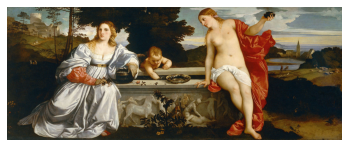

In [ ]:
# Predict from web - this is an image of Titian.
url = 'https://www.italian-renaissance-art.com/images/Titian-Sacred-ProfoundLove.jpg'
#url='https://www.italian-renaissance-art.com/images/Titian-Assumption-Frari-Altar.jpg'
#url='https://www.pablopicasso.org/images/paintings/self-portrait-1907.jpg'
import imageio
import cv2
from keras_preprocessing.image import load_img, img_to_array



labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)

prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)
print("prediction_idx: ",prediction_idx)
print("labels: ",labels)
#print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()

>> Save

In [ ]:
export_dir = '/content/drive/MyDrive/ArtistPrediction/artist_prediction/'

model.save(export_dir, save_format="tf", include_optimizer=False)


In [ ]:
import tarfile
tar = tarfile.open("/content/drive/MyDrive/ArtistPrediction/artist_prediction/artistprediction.tar.gz", "w:gz")
tar.add("/content/drive/MyDrive/ArtistPrediction/artist_prediction")
tar.close()

In [ ]:
trace = torch.jit.trace(resnet18.float().eval(), torch.zeros(input_shape).float())
trace.save("model.pth")

with tarfile.open("model.tar.gz", "w:gz") as f:
    f.add("model.pth")

In [ ]:
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4")
])
m.build([None, 224, 224, 3])  # Batch input shape.
m.save("artistpredictionv2") # defaults to save as SavedModel in tensorflow 2

In [ ]:
import tarfile
tar = tarfile.open("artistpredictionv2.tar.gz", "w:gz")
tar.add("artistpredictionv2")
tar.close()

In [ ]:
import tensorflow_hub as hub
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4")
])
m.build([None, 224, 224, 3])  # Batch input shape.
m.save("/content/drive/MyDrive/ArtistPrediction/artist_prediction") # defaults to save as SavedModel in tensorflow 2

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend

tf.keras.backend.set_learning_phase(0)
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
model.summary()

# Save as a SavedModel
export_dir = '/content/drive/MyDrive/ArtistPrediction/artist_prediction/'
model.save(export_dir, save_format='tf')

# Freeze saved model
input_node_names = [inp.name.split(":")[0] for inp in model.inputs]
output_node_names = [output.name.split(":")[0] for output in model.outputs]
#print("Input names: ", input_node_names)


In [ ]:
#with tf.Session() as sess:
loaded = tf.saved_model.load(export_dir=export_dir, tags=["serve"]) 

#tf.saved_model.save(pretrained_model, mobilenet_save_path)

frozen_graph = tf.core.train_utils.convert_variables_to_constants_v2_as_graph(output_node_names)
tf.io.write_graph(graph_or_graph_def=frozen_graph, logdir=".", name="artist_prediction.pb", as_text=False)   

import tarfile
tar = tarfile.open("artist_prediction.tar.gz", "w:gz")
tar.add("/content/drive/MyDrive/ArtistPrediction/artist_prediction/artist_prediction.pb")
tar.close()

In [ ]:
frozen_graph = tf.graph_util.convert_variables_to_constants_v2_as_graph(output_node_names)
tf.io.write_graph(graph_or_graph_def=frozen_graph, logdir=".", name="artist_prediction.pb", as_text=False)   

import tarfile
tar = tarfile.open("artist_prediction.tar.gz", "w:gz")
tar.add("/content/drive/MyDrive/ArtistPrediction/artist_prediction/artist_prediction.pb")
tar.close()

In [ ]:
tfm.core.train_utils.convert_variables_to_constants_v2_as_graph(
    func, lower_control_flow=True, aggressive_inlining=False
)


In [ ]:
# Save the model to local storage
model.save("drive/MyDrive/ArtistPrediction/")

In [ ]:
import tarfile
tarfile_name='drive/MyDrive/ArtistPrediction/artistprediction.tar.gz'


with tarfile.open(tarfile_name, mode='w:gz') as archive:
       archive.add('artistprediction.pb') 

In [ ]:
import tarfile
tar = tarfile.open("savedmodel.tar.gz", "w:gz")
tar.add("/content/drive/MyDrive/artist_prediction/saved_model.pb")
tar.close()


In [ ]:
#model.save("artistprediction.h5")

export_dir = 'saved_model/'
model.save(export_dir, save_format='tf')


# Freeze saved model
input_node_names = [inp.name.split(":")[0] for inp in model.inputs]
output_node_names = [output.name.split(":")[0] for output in model.outputs]
print("Input names: ", input_node_names)
print(export_dir)

In [ ]:
graph =tf.compat.v1.get_default_graph()

In [ ]:
with tf.compat.v1.Session(graph=graph) as sess:
    loaded = tf.compat.v1.saved_model.load(sess, export_dir=export_dir, tags=["serve"]) 
    frozen_graph = tf.compat.v1.graph_util.convert_variables_to_constants(sess,
                                                                sess.graph.as_graph_def(),
                                                                output_node_names)
    tf.compat.v1.io.write_graph(graph_or_graph_def=frozen_graph, logdir=".", name="artistprediction.pb", as_text=False)

import tarfile
tar = tarfile.open("artistprediction.tar.gz", "w:gz")
tar.add("artistprediction.pb")
tar.close()


In [ ]:
import tarfile
   
tarfile_name='/content/drive/MyDrive/artistprediction.tar.gz'
   
with tarfile.open(tarfile_name, mode='w:gz') as archive:
  archive.add('artistprediction.h5')